In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import numpy as np

from linearmodels.panel import PanelOLS
import datetime as dt

# Characteristics OLS

Professor said we should start with a regular OLS Regression.
I quickly looked into this and think a random effects panel regression would probably fit our data better (still need to read more into this)
So probably we can first do a regular OLS and than compare it to the random effects panel regression. Just some initial thoughts though!!!
Here is some intial code to run them:


In [2]:
#decide which df to use
df = pd.read_csv("macro_2.csv")
#df = df.loc[:, ["Instrument", "Date", "Earnings Per Share - Actual Surprise", "Revenue - Actual", "Net Income after Tax"]]
X_var_names = ["WACC Inflation Adjusted Risk Free Rate, (%)", "Inflation Premium(%)", "90-Day AA Financial Commercial Paper Interest Rate", "CPFFM",
               "CBOE Crude Oil ETF Volatility Index", "Consumer Sentiment", "Unemployment rate"]
df

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,"WACC Inflation Adjusted Risk Free Rate, (%)",Inflation Premium(%),90-Day AA Financial Commercial Paper Interest Rate,CPFFM,CBOE Crude Oil ETF Volatility Index,Consumer Sentiment,Unemployment rate
0,AVY.N,2013-01-01,Materials,11.178,NaN,0.359537,0.17,0.02,22.54,76.67,7.733333
1,AVY.N,2013-04-01,Materials,2.482,NaN,0.360572,0.14,0.03,23.47,81.67,7.533333
2,AVY.N,2013-07-01,Materials,1.068,NaN,0.463789,0.13,0.04,24.10,81.57,7.233333
3,AVY.N,2013-10-01,Materials,8.095,NaN,0.441854,0.13,0.04,19.74,76.93,6.933333
4,AVY.N,2014-01-01,Materials,1.471,NaN,0.465460,0.13,0.05,19.56,80.93,6.666667
...,...,...,...,...,...,...,...,...,...,...,...
20115,POOL.OQ,2021-10-01,Retailing,17.194,1.527139,0.382645,0.14,0.06,43.04,69.90,4.200000
20116,POOL.OQ,2022-01-01,Retailing,40.267,1.515266,0.380946,0.47,0.32,52.70,63.13,3.800000
20117,POOL.OQ,2022-04-01,Retailing,34.342,2.325202,0.495588,1.39,0.61,50.46,57.87,3.600000
20118,POOL.OQ,2022-07-01,Retailing,1.503,3.092855,0.423045,2.89,0.64,49.86,56.10,3.566667


#### OLS Regression

In [3]:
#identifying outliers and replacing them with NA
summary_stats = df["Earnings Per Share - Actual Surprise"].describe()
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
IQR = Q3 - Q1
threshold = 7 #1.5 is standard threshold but we still want to keep enough variation in the data so setting threshol higher here
surprise_outliers_removed = df["Earnings Per Share - Actual Surprise"].loc[~((df["Earnings Per Share - Actual Surprise"] < (Q1 - threshold * IQR)) | (df["Earnings Per Share - Actual Surprise"] > (Q3 + threshold * IQR)))]
df_accuracy_new = df.copy()
df_accuracy_new["Earnings Per Share - Actual Surprise"] = surprise_outliers_removed
df_accuracy_new = df_accuracy_new.dropna(subset=["Earnings Per Share - Actual Surprise"])
#df_accuracy_new["Recommendation - Mean (1-5)"] = df_accuracy_new["Recommendation - Mean (1-5)"].fillna(0)
df_accuracy_new = df_accuracy_new.dropna()


In [4]:
df_accuracy_new

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,"WACC Inflation Adjusted Risk Free Rate, (%)",Inflation Premium(%),90-Day AA Financial Commercial Paper Interest Rate,CPFFM,CBOE Crude Oil ETF Volatility Index,Consumer Sentiment,Unemployment rate
12,AVY.N,2016-01-01,Materials,8.817,2.304994,0.420570,0.55,0.19,58.78,91.57,4.900000
13,AVY.N,2016-04-01,Materials,9.159,1.829833,0.383655,0.56,0.18,42.38,92.40,4.933333
14,AVY.N,2016-07-01,Materials,7.522,1.491713,0.406042,0.70,0.30,39.96,90.33,4.900000
15,AVY.N,2016-10-01,Materials,1.290,1.606498,0.454642,0.77,0.32,38.25,93.07,4.766667
16,AVY.N,2017-01-01,Materials,6.180,2.431507,0.444016,0.92,0.22,29.34,97.23,4.566667
...,...,...,...,...,...,...,...,...,...,...,...
20115,POOL.OQ,2021-10-01,Retailing,17.194,1.527139,0.382645,0.14,0.06,43.04,69.90,4.200000
20116,POOL.OQ,2022-01-01,Retailing,40.267,1.515266,0.380946,0.47,0.32,52.70,63.13,3.800000
20117,POOL.OQ,2022-04-01,Retailing,34.342,2.325202,0.495588,1.39,0.61,50.46,57.87,3.600000
20118,POOL.OQ,2022-07-01,Retailing,1.503,3.092855,0.423045,2.89,0.64,49.86,56.10,3.566667


In [10]:
rescale = df_accuracy_new
#rescale["Earnings Per Share - Actual Surprise"] = MinMaxScaler().fit_transform(np.array(rescale["Earnings Per Share - Actual Surprise"]).reshape(-1,1))
rescale["WACC Inflation Adjusted Risk Free Rate, (%)"] = MinMaxScaler().fit_transform(np.array(rescale["WACC Inflation Adjusted Risk Free Rate, (%)"]).reshape(-1,1))
rescale["Inflation Premium(%)"] = MinMaxScaler().fit_transform(np.array(rescale["Inflation Premium(%)"]).reshape(-1,1))
rescale["90-Day AA Financial Commercial Paper Interest Rate"] = MinMaxScaler().fit_transform(np.array(rescale["90-Day AA Financial Commercial Paper Interest Rate"]).reshape(-1,1))
rescale["CPFFM"] = MinMaxScaler().fit_transform(np.array(rescale["CPFFM"]).reshape(-1,1))
rescale["CBOE Crude Oil ETF Volatility Index"] = MinMaxScaler().fit_transform(np.array(rescale["CBOE Crude Oil ETF Volatility Index"]).reshape(-1,1))
rescale["Consumer Sentiment"] = MinMaxScaler().fit_transform(np.array(rescale["Consumer Sentiment"]).reshape(-1,1))
rescale["Unemployment rate"] = MinMaxScaler().fit_transform(np.array(rescale["Unemployment rate"]).reshape(-1,1))

rescale

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,"WACC Inflation Adjusted Risk Free Rate, (%)",Inflation Premium(%),90-Day AA Financial Commercial Paper Interest Rate,CPFFM,CBOE Crude Oil ETF Volatility Index,Consumer Sentiment,Unemployment rate
12,AVY.N,2016-01-01,Materials,8.817,0.646376,0.708327,0.108959,0.383562,0.422695,0.828158,0.141844
13,AVY.N,2016-04-01,Materials,9.159,0.530450,0.614380,0.111380,0.369863,0.216379,0.847537,0.145390
14,AVY.N,2016-07-01,Materials,7.522,0.447959,0.671354,0.145278,0.534247,0.185935,0.799206,0.141844
15,AVY.N,2016-10-01,Materials,1.290,0.475963,0.795039,0.162228,0.561644,0.164423,0.863180,0.127660
16,AVY.N,2017-01-01,Materials,6.180,0.677241,0.767996,0.198547,0.424658,0.052334,0.960308,0.106383
...,...,...,...,...,...,...,...,...,...,...,...
20115,POOL.OQ,2021-10-01,Retailing,17.194,0.456602,0.611807,0.009685,0.205479,0.224682,0.322204,0.067376
20116,POOL.OQ,2022-01-01,Retailing,40.267,0.453705,0.607483,0.089588,0.561644,0.346207,0.164137,0.024823
20117,POOL.OQ,2022-04-01,Retailing,34.342,0.651306,0.899246,0.312349,0.958904,0.318027,0.041326,0.003546
20118,POOL.OQ,2022-07-01,Retailing,1.503,0.838591,0.714626,0.675545,1.000000,0.310479,0.000000,0.000000


In [11]:
for_rf = rescale
#.iloc[0:38, :]
for_rf = for_rf.iloc[::-1].reset_index(drop=True)


# print the reversed DataFrame
for_rf

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,"WACC Inflation Adjusted Risk Free Rate, (%)",Inflation Premium(%),90-Day AA Financial Commercial Paper Interest Rate,CPFFM,CBOE Crude Oil ETF Volatility Index,Consumer Sentiment,Unemployment rate
0,POOL.OQ,2022-10-01,Retailing,4.196,0.998286,1.000000,1.000000,0.986301,0.274500,0.063040,0.003546
1,POOL.OQ,2022-07-01,Retailing,1.503,0.838591,0.714626,0.675545,1.000000,0.310479,0.000000,0.000000
2,POOL.OQ,2022-04-01,Retailing,34.342,0.651306,0.899246,0.312349,0.958904,0.318027,0.041326,0.003546
3,POOL.OQ,2022-01-01,Retailing,40.267,0.453705,0.607483,0.089588,0.561644,0.346207,0.164137,0.024823
4,POOL.OQ,2021-10-01,Retailing,17.194,0.456602,0.611807,0.009685,0.205479,0.224682,0.322204,0.067376
...,...,...,...,...,...,...,...,...,...,...,...
12855,AVY.N,2017-01-01,Materials,6.180,0.677241,0.767996,0.198547,0.424658,0.052334,0.960308,0.106383
12856,AVY.N,2016-10-01,Materials,1.290,0.475963,0.795039,0.162228,0.561644,0.164423,0.863180,0.127660
12857,AVY.N,2016-07-01,Materials,7.522,0.447959,0.671354,0.145278,0.534247,0.185935,0.799206,0.141844
12858,AVY.N,2016-04-01,Materials,9.159,0.530450,0.614380,0.111380,0.369863,0.216379,0.847537,0.145390


In [12]:
corr_matrix = for_rf.corr()

# print the correlation matrix
print(corr_matrix)

                                                    Earnings Per Share - Actual Surprise  \
Earnings Per Share - Actual Surprise                                            1.000000   
WACC Inflation Adjusted Risk Free Rate, (%)                                    -0.121081   
Inflation Premium(%)                                                           -0.028817   
90-Day AA Financial Commercial Paper Interest Rate                             -0.119716   
CPFFM                                                                          -0.088200   
CBOE Crude Oil ETF Volatility Index                                            -0.018555   
Consumer Sentiment                                                             -0.047427   
Unemployment rate                                                               0.079249   

                                                    WACC Inflation Adjusted Risk Free Rate, (%)  \
Earnings Per Share - Actual Surprise                                    

/var/folders/48/zl9xdnts1pgch2fdmc_lcyl40000gn/T/ipykernel_44839/869648261.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = for_rf.corr()


<Axes: >

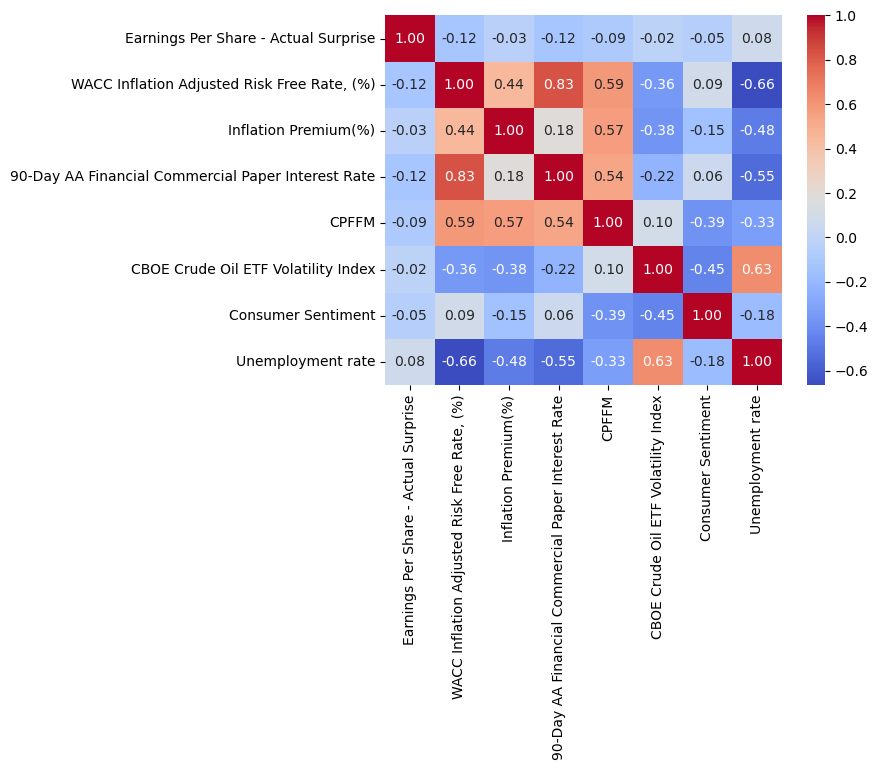

In [13]:
import seaborn as sns

# plot a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')

In [15]:
# Import libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load data

X_var_names = ["WACC Inflation Adjusted Risk Free Rate, (%)", "Inflation Premium(%)", "90-Day AA Financial Commercial Paper Interest Rate", "CPFFM",
               "CBOE Crude Oil ETF Volatility Index", "Consumer Sentiment", "Unemployment rate"]

# Define features and target
X = for_rf[X_var_names]
y = for_rf["Earnings Per Share - Actual Surprise"]

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a random forest regressor with 100 trees
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model to the training data
rf.fit(X_train, y_train)

# predict the target variable on the test data
y_pred = rf.predict(X_test)

# evaluate the performance of the model
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error:', mse)

Mean squared error: 301.80445199982205


In [5]:
y = df_accuracy_new["Earnings Per Share - Actual Surprise"]
#X = df_accuracy_new[['Revenue - Actual', 'Net Income after Tax']]
X = df_accuracy_new[]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     Earnings Per Share - Actual Surprise   R-squared:                       0.015
Model:                                              OLS   Adj. R-squared:                  0.015
Method:                                   Least Squares   F-statistic:                     95.67
Date:                                  Tue, 28 Feb 2023   Prob (F-statistic):           5.73e-42
Time:                                          16:15:04   Log-Likelihood:                -54926.
No. Observations:                                 12860   AIC:                         1.099e+05
Df Residuals:                                     12857   BIC:                         1.099e+05
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          13.5261      0.978     13.834      0.000      11.610      15.443
WACC Inflation Adjusted Risk Free Rate, (%)    -2.8073      0.268    -10.459      0.000      -3.333      -2.281
Unemployment rate                              -0.0203      0.107     -0.190      0.849      -0.230       0.189
==============================================================================
Omnibus:                     2185.351   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19557.378
Skew:                           0.554   Prob(JB):                         0.00
Kurtosis:                       8.939   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### OLS Pooled Regression

In [6]:
df_accuracy_new['Date'] = pd.to_datetime(df_accuracy_new['Date'], infer_datetime_format=True)
df_accuracy_new.dtypes

Instrument                                                    object
Date                                                  datetime64[ns]
GICS Industry Group Name                                      object
Earnings Per Share - Actual Surprise                         float64
WACC Inflation Adjusted Risk Free Rate, (%)                  float64
Inflation Premium(%)                                         float64
90-Day AA Financial Commercial Paper Interest Rate           float64
CPFFM                                                        float64
CBOE Crude Oil ETF Volatility Index                          float64
Consumer Sentiment                                           float64
Unemployment rate                                            float64
dtype: object

In [7]:
#df_accuracy_new.set_index(["Instrument", "Date"], inplace=True)
df_accuracy_new

,Instrument,Date,GICS Industry Group Name,Earnings Per Share - Actual Surprise,"WACC Inflation Adjusted Risk Free Rate, (%)",Inflation Premium(%),90-Day AA Financial Commercial Paper Interest Rate,CPFFM,CBOE Crude Oil ETF Volatility Index,Consumer Sentiment,Unemployment rate
12,AVY.N,2016-01-01,Materials,8.817,2.304994,0.420570,0.55,0.19,58.78,91.57,4.900000
13,AVY.N,2016-04-01,Materials,9.159,1.829833,0.383655,0.56,0.18,42.38,92.40,4.933333
14,AVY.N,2016-07-01,Materials,7.522,1.491713,0.406042,0.70,0.30,39.96,90.33,4.900000
15,AVY.N,2016-10-01,Materials,1.290,1.606498,0.454642,0.77,0.32,38.25,93.07,4.766667
16,AVY.N,2017-01-01,Materials,6.180,2.431507,0.444016,0.92,0.22,29.34,97.23,4.566667
...,...,...,...,...,...,...,...,...,...,...,...
20115,POOL.OQ,2021-10-01,Retailing,17.194,1.527139,0.382645,0.14,0.06,43.04,69.90,4.200000
20116,POOL.OQ,2022-01-01,Retailing,40.267,1.515266,0.380946,0.47,0.32,52.70,63.13,3.800000
20117,POOL.OQ,2022-04-01,Retailing,34.342,2.325202,0.495588,1.39,0.61,50.46,57.87,3.600000
20118,POOL.OQ,2022-07-01,Retailing,1.503,3.092855,0.423045,2.89,0.64,49.86,56.10,3.566667


# with grouping


In [8]:
from statsmodels.iolib.summary2 import summary_col
# Split the DataFrame into groups based on the stocks
df = df_accuracy_new[df_accuracy_new['GICS Industry Group Name'] == 'Technology Hardware & Equipment']
groups = df.groupby('Instrument')

# Define a function to perform OLS regression on each group
def ols_regression(group):
    # Define the dependent and independent variables
    if len(group) < 2:
        return None
    y = group['Earnings Per Share - Actual Surprise']
    X = group[X_var_names]

    # Add a constant to the independent variables
    X = sm.add_constant(X)

    # Fit the OLS model and return the results
    model = sm.OLS(y, X).fit()
    return model

# Apply the function to each group of data
results = groups.apply(ols_regression)
results = results.dropna()
# Collect the results into a new DataFrame

# Print the coefficients, t-values, and p-values
# print('Coefficients:')
# print(coefficients)
# print('\nT-values:')
# print(t_values)
# print('\nP-values:')
models = results.tolist()
summary = summary_col(models, stars=True, float_format='%0.2f', model_names=results.index.tolist())

# Print the combined summary table
summary

,AAPL.OQ,ANET.N,APH.N,CDW.OQ,CSCO.OQ,FFIV.OQ,GLW.N,HPE.N,HPQ.N,JNPR.N,KEYS.N,MSI.N,NTAP.OQ,STX.OQ,TDY.N,TEL.N,TRMB.OQ,WDC.OQ,ZBRA.OQ
const,10.41,-1.29,17.59**,20.16***,4.98,-3.49,2.86,21.03,15.69,2.96,37.90**,2.60,18.24,34.78,27.19,-2.63,14.20,55.86**,17.50
,(11.60),(11.07),(8.05),(6.38),(3.60),(5.37),(5.52),(16.58),(12.28),(9.04),(14.41),(8.63),(18.43),(30.57),(16.07),(6.11),(9.94),(24.03),(11.25)
"WACC Inflation Adjusted Risk Free Rate, (%)",-3.69,5.85*,-3.51,-4.60**,-0.30,1.67,-1.51,-1.14,-5.92*,2.67,-4.47,1.26,-6.64,-17.24**,-2.77,-3.00,-6.02**,-17.09**,-3.24
,(3.20),(3.05),(2.22),(1.76),(0.63),(1.48),(1.53),(4.61),(3.40),(2.49),(3.97),(2.38),(5.08),(4.16),(4.43),(2.18),(2.73),(6.62),(3.10)
Unemployment rate,1.03,0.78,-0.44,-0.71,-0.54,1.15*,1.32**,-1.74,0.38,-0.60,-3.81**,1.22,1.83,-1.47,-1.32,3.23***,1.84*,-3.34,-0.83
,(1.24),(1.19),(0.86),(0.68),(0.61),(0.58),(0.61),(1.80),(1.33),(0.97),(1.54),(0.93),(1.98),(6.08),(1.72),(0.88),(1.04),(2.58),(1.21)
R-squared,0.20,0.15,0.11,0.24,0.16,0.14,0.37,0.05,0.20,0.15,0.21,0.07,0.24,0.90,0.02,0.61,0.55,0.22,0.04
R-squared Adj.,0.13,0.08,0.04,0.18,-0.26,0.07,0.31,-0.03,0.13,0.09,0.15,-0.00,0.18,0.84,-0.05,0.58,0.51,0.16,-0.03
